<center><h1>DSCI-552 Homework 3</h1></center>
<br>
<center><font size="4">Name: Wenhao Zhang</font></center>
<center><font size="4">USC ID: 7036767117</font></center>

## 1. Time Series Classification

### (a) Download and read data

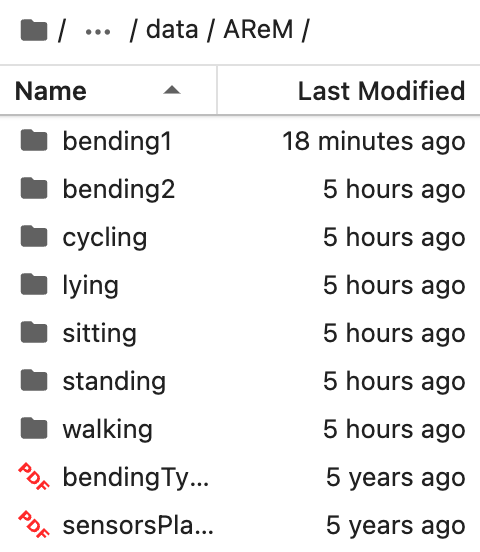

Have downloaded them!

And let us read data here.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import statsmodels.api as sm
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

df = pd.DataFrame()
count = 0
folder_list = os.listdir("../data/AReM")
folder_list.sort()
for folder in folder_list:
    if (folder[0]=='.')|(folder[-3:]=='pdf'):
        continue
    else:
        # print(folder)
        file_list = os.listdir("../data/AReM/" + folder)
        if '.ipynb_checkpoints' in file_list: file_list.remove('.ipynb_checkpoints')
        if '.DS_Store' in file_list: file_list.remove('.DS_Store')
        file_list = sorted(file_list, key=lambda x: int(x[7:-4]), reverse=False)
        # print(file_list)
        for file in file_list:
            # print(file)
            count += 1
            file_df = pd.read_csv("../data/AReM/"+folder+"/"+file, header=0, sep=",", skiprows=4)
            file_df['folder'] = folder
            file_df['file'] = file[:-4]
            file_df['instance'] = count
            if len(file_df) != 480: # check if time series miss values 
                print(folder+"/"+file, len(file_df))
            df = pd.concat([df, file_df], axis=0)
df = df.rename(columns={'# Columns: time': 'time'})
# print(count)
df

# There is a redundant ',' in /cycling/dataset9.csv, and I just delete it.
# There is a redundant ',' in /cycling/dataset14.csv, and I just delete it.
# There is a line missing in /sitting/dataset8.csv #60, which should represent the data of time 13500, and I add
# a line in that position with the average values of the features of time 13250 and 13750.
# /bending2/dataset4.csv is separated by ' ', I change it to be separated by ','

time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23  \
0         0      39.25       0.43      22.75       0.43      33.75       1.30   
1       250      39.25       0.43      23.00       0.00      33.00       0.00   
2       500      39.25       0.43      23.25       0.43      33.00       0.00   
3       750      39.50       0.50      23.00       0.71      33.00       0.00   
4      1000      39.50       0.50      24.00       0.00      33.00       0.00   
..      ...        ...        ...        ...        ...        ...        ...   
475  118750      34.50       6.18       9.00       3.56      12.67       4.19   
476  119000      25.75       6.02      13.75       2.05      16.00       1.58   
477  119250      31.50       3.35      10.25       5.12      16.25       2.95   
478  119500      33.75       2.77      14.00       3.24      13.75       0.43   
479  119750      37.00       1.41      18.25       3.70      11.00       4.32   

       folder       file  instance  
0    bending1   dataset1         1  
1    bending1   dataset1         1  
2    bending1   dataset1         1  
3    bending1   dataset1         1  
4    bending1   dataset1         1  
..        ...        ...       ...  
475   walking  dataset15        88  
476   walking  dataset15        88  
477   walking  dataset15        88  
478   walking  dataset15        88  
479   walking  dataset15        88  

[42240 rows x 10 columns]

### (b) Split the data set

Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [2]:
test_condition = (((df['folder'] == 'bending1')&(df['file'] == 'dataset1')) | 
                  ((df['folder'] == 'bending1')& (df['file'] == 'dataset2')) |
                  ((df['folder'] == 'bending2')&(df['file'] == 'dataset1')) |
                  ((df['folder'] == 'bending2')&(df['file'] == 'dataset2')) |
                  ((df['folder'] == 'cycling')&(df['file'] == 'dataset1')) |
                  ((df['folder'] == 'cycling')&(df['file'] == 'dataset2')) |
                  ((df['folder'] == 'cycling')&(df['file'] == 'dataset3')) |
                  ((df['folder'] == 'lying')&(df['file'] == 'dataset1')) |
                  ((df['folder'] == 'lying')&(df['file'] == 'dataset2')) |
                  ((df['folder'] == 'lying')&(df['file'] == 'dataset3')) |
                  ((df['folder'] == 'sitting')&(df['file'] == 'dataset1')) |
                  ((df['folder'] == 'sitting')&(df['file'] == 'dataset2')) |
                  ((df['folder'] == 'sitting')&(df['file'] == 'dataset3')) |
                  ((df['folder'] == 'standing')&(df['file'] == 'dataset1')) |
                  ((df['folder'] == 'standing')&(df['file'] == 'dataset2')) |
                  ((df['folder'] == 'standing')&(df['file'] == 'dataset3')) |
                  ((df['folder'] == 'walking')&(df['file'] == 'dataset1')) |
                  ((df['folder'] == 'walking')&(df['file'] == 'dataset2')) |
                  ((df['folder'] == 'walking')&(df['file'] == 'dataset3')))
test_df = df[test_condition]
train_df = df[~test_condition]
print(train_df.shape)
print(test_df.shape)

(33120, 10)
(9120, 10)


### (c) Feature Extraction

Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.

#### i. 
Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc). 

**Simple statistical features**
* **Means** in each of the 𝑑 dimensions
* **Standard deviations** of the 𝑑 dimensions
* **Skewness**, **Kurtosis** and Higher order moments of the 𝑑 dimensions
* **Maximum** and **Minimum** values

**Time serie analysis related features**
* The 𝑑×𝑑−1 **Cross-Correlations** between each dimension and the 𝑑 **Auto-Correlations**
* **Orders** of the autoregressive (AR), integrated (I) and moving average (MA) part of an estimated ARIMA model
* **Parameters** of the AR part
* **Parameters** of the MA part

**Frequency domain related features**
* frequencies of the **𝑘 peaks** in amplitude in the DFTs for the detrended 𝑑 dimensions
* **𝑘-quantiles** of these DFTs

**Citation**: Emile (https://stats.stackexchange.com/users/16137/emile), Features for time series classification, URL (version: 2014-08-21): https://stats.stackexchange.com/q/51474

#### ii. 
Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [3]:
count = 0
td_features_df = pd.DataFrame()
subscript = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉") # printing subscript
feature_list = list(df.columns)[1:-3]
for feature in feature_list:
    count += 1
    feature_df = pd.concat([df[feature].groupby(df['instance']).min(), df[feature].groupby(df['instance']).max(), 
                            df[feature].groupby(df['instance']).mean(), df[feature].groupby(df['instance']).median(), 
                            df[feature].groupby(df['instance']).std(), df[feature].groupby(df['instance']).quantile(q=0.25), 
                            df[feature].groupby(df['instance']).quantile(q=0.75)], axis=1)
    feature_df.columns = ["min"+str(count).translate(subscript), "max"+str(count).translate(subscript), 
                          "mean"+str(count).translate(subscript), "median"+str(count).translate(subscript),
                          "standard deviation"+str(count).translate(subscript),
                          "1st quart"+str(count).translate(subscript), "3rd quart"+str(count).translate(subscript)]
    td_features_df = pd.concat([td_features_df, feature_df], axis=1)
td_features_df

min₁   max₁      mean₁  median₁  standard deviation₁  1st quart₁  \
instance                                                                      
1         37.25  45.00  40.624792    40.50             1.476967       39.25   
2         38.00  45.67  42.812812    42.50             1.435550       42.00   
3         35.00  47.40  43.954500    44.33             1.558835       43.00   
4         33.00  47.75  42.179813    43.50             3.670666       39.15   
5         33.00  45.75  41.678063    41.75             2.243490       41.33   
...         ...    ...        ...      ...                  ...         ...   
84        19.50  45.33  33.586875    34.25             4.650935       30.25   
85        19.75  45.50  34.322750    35.25             4.752477       31.00   
86        19.50  46.00  34.546229    35.25             4.842294       31.25   
87        23.50  46.25  34.873229    35.25             4.531720       31.75   
88        19.25  44.00  34.473188    35.00             4.796705       31.25   

          3rd quart₁  min₂   max₂     mean₂  ...  standard deviation₅  \
instance                                     ...                        
1            42.0000   0.0   1.30  0.358604  ...             2.188449   
2            43.6700   0.0   1.22  0.372438  ...             1.995255   
3            45.0000   0.0   1.70  0.426250  ...             1.999604   
4            45.0000   0.0   3.00  0.696042  ...             3.849448   
5            42.7500   0.0   2.83  0.535979  ...             2.411026   
...              ...   ...    ...       ...  ...                  ...   
84           37.0000   0.0  14.67  4.576562  ...             3.283983   
85           38.0000   0.0  13.47  4.456333  ...             3.119856   
86           37.8125   0.0  12.47  4.371958  ...             2.823124   
87           38.2500   0.0  14.82  4.380583  ...             3.131076   
88           38.0000   0.0  13.86  4.359312  ...             3.156320   

          1st quart₅  3rd quart₅  min₆   max₆     mean₆  median₆  \
instance                                                           
1            33.0000       36.00  0.00   1.92  0.570583     0.43   
2            32.0000       34.50  0.00   3.11  0.571083     0.43   
3            35.3625       36.50  0.00   1.79  0.493292     0.43   
4            30.4575       36.33  0.00   2.18  0.613521     0.50   
5            28.4575       31.25  0.00   1.79  0.383292     0.43   
...              ...         ...   ...    ...       ...      ...   
84           13.7300       18.25  0.00   8.32  3.259729     3.11   
85           13.5000       17.75  0.00   9.67  3.432562     3.20   
86           14.0000       17.75  0.00  10.00  3.338125     3.08   
87           13.7500       18.00  0.00   9.51  3.424646     3.27   
88           13.7300       17.75  0.43   9.00  3.340458     3.09   

          standard deviation₆  1st quart₆  3rd quart₆  
instance                                               
1                    0.582915      0.0000      1.3000  
2                    0.601010      0.0000      1.3000  
3                    0.513506      0.0000      0.9400  
4                    0.524317      0.0000      1.0000  
5                    0.389164      0.0000      0.5000  
...                       ...         ...         ...  
84                   1.640243      2.0500      4.3225  
85                   1.732727      2.1575      4.5650  
86                   1.656742      2.1600      4.3350  
87                   1.690960      2.1700      4.5000  
88                   1.699114      2.1200      4.3750  

[88 rows x 42 columns]

#### iii. 
Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootstrap confidence interval for the standard deviation of each feature.

In [4]:
n_iterations = 10000 # time of iterations
n_size = len(td_features_df) # size of samples
bootstrap_std = []
for i in range(n_iterations):
    sample_std = dict(resample(td_features_df, n_samples=n_size).std())
    bootstrap_std.append(sample_std)
bootstrap_std = pd.DataFrame(bootstrap_std)

alpha = 0.9
# get 90% bootstrap confidence interval
bootstrap_ci = bootstrap_std.apply(lambda x: (x.quantile(q=(1-alpha)/2), x.quantile(q=alpha+(1-alpha)/2))).T
bootstrap_ci.columns = ['lower', 'upper']
bootstrap_ci['bootstrap_ci'] = '(' + bootstrap_ci['lower'].map(str) + ', ' + bootstrap_ci['upper'].map(str) + ')'
bootstrap_ci = bootstrap_ci.drop(['lower', 'upper'], axis=1)
estimate = td_features_df.std()
estimate_and_ci = pd.concat([estimate, bootstrap_ci], axis=1)
estimate_and_ci.columns = ['estimate', '90%_bootstrap_ci']
estimate_and_ci

estimate                           90%_bootstrap_ci
min₁                 9.569975     (8.24696746955057, 10.756410213050424)
max₁                 4.394362    (3.3310677979316043, 5.294632127336234)
mean₁                5.335703     (4.704634654403259, 5.878992873026909)
median₁              5.440054    (4.780905806178936, 5.9991129542253985)
standard deviation₁  1.772155   (1.5731492347605434, 1.9479526784289418)
1st quart₁           6.153590     (5.560815514844179, 6.637610781928053)
3rd quart₁           5.138925     (4.319301141303154, 5.841385398387216)
min₂                 0.000000                                 (0.0, 0.0)
max₂                 5.062729     (4.626826389288107, 5.400107026410263)
mean₂                1.574170   (1.3987555745413065, 1.7065859729463562)
median₂              1.412244    (1.239365538824889, 1.5466992619683169)
standard deviation₂  0.884104   (0.8040553668006786, 0.9415664159672112)
1st quart₂           0.946386    (0.8304523652602513, 1.036043962998499)
3rd quart₂           2.125266   (1.8972169756070087, 2.2970684500264014)
min₃                 2.956462    (2.759185785785066, 3.1059879485214066)
max₃                 4.875137      (4.153687299176625, 5.45977956054695)
mean₃                4.008386     (3.412906185675253, 4.492599139536342)
median₃              4.036396    (3.4243502311534226, 4.539374165622606)
standard deviation₃  0.946695   (0.7621947396365069, 1.1196235020064833)
1st quart₃           4.220658    (3.6242720921024256, 4.697907805504132)
3rd quart₃           4.171628   (3.5381158510113773, 4.6872835803292565)
min₄                 0.000000                                 (0.0, 0.0)
max₄                 2.183625    (1.9712328310143656, 2.361209677593115)
mean₄                1.166071    (1.076880364227022, 1.2230302328852685)
median₄              1.145586    (1.0578801557590571, 1.202293255079347)
standard deviation₄  0.458200  (0.4216463713762919, 0.48571353529173733)
1st quart₄           0.843620   (0.7758798279434775, 0.8908985068077647)
3rd quart₄           1.552504   (1.4350492733077078, 1.6283166563978384)
min₅                 6.124001     (4.421996943103177, 7.527461978349893)
max₅                 5.741238     (4.757188229989995, 6.560451855665408)
mean₅                5.675593     (4.423221492090932, 6.732745465568991)
median₅              5.813782     (4.515153052791079, 6.902225081258388)
standard deviation₅  1.024873    (0.8129919334359704, 1.214057285173904)
1st quart₅           6.096465     (4.802751385821962, 7.207011354742047)
3rd quart₅           5.531720     (4.339887541302429, 6.527992814040128)
min₆                 0.045838                 (0.0, 0.07847613098768456)
max₆                 2.518921   (2.2498852958876623, 2.7593587135198545)
mean₆                1.154771   (1.0629816291732066, 1.2154173600828573)
median₆              1.086474    (0.995490713124931, 1.1484486352829075)
standard deviation₆  0.517567   (0.4794661223117654, 0.5449220038321673)
1st quart₆           0.758584   (0.6896889265866055, 0.8079916277821122)
3rd quart₆           1.523599    (1.4033341950788267, 1.600883641983908)

#### iv. 
Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

**ANSWER**: My choice would be **mean**, **median**, and **standard deviation**. In my opinion, mean shows the center of the data and std shows the fluctuation degree of the data. I choose median because it show the center of the data in another way which could ignore the influence of extreme values.

### (d) Binary Classification Using Logistic Regression

#### i. 
Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).

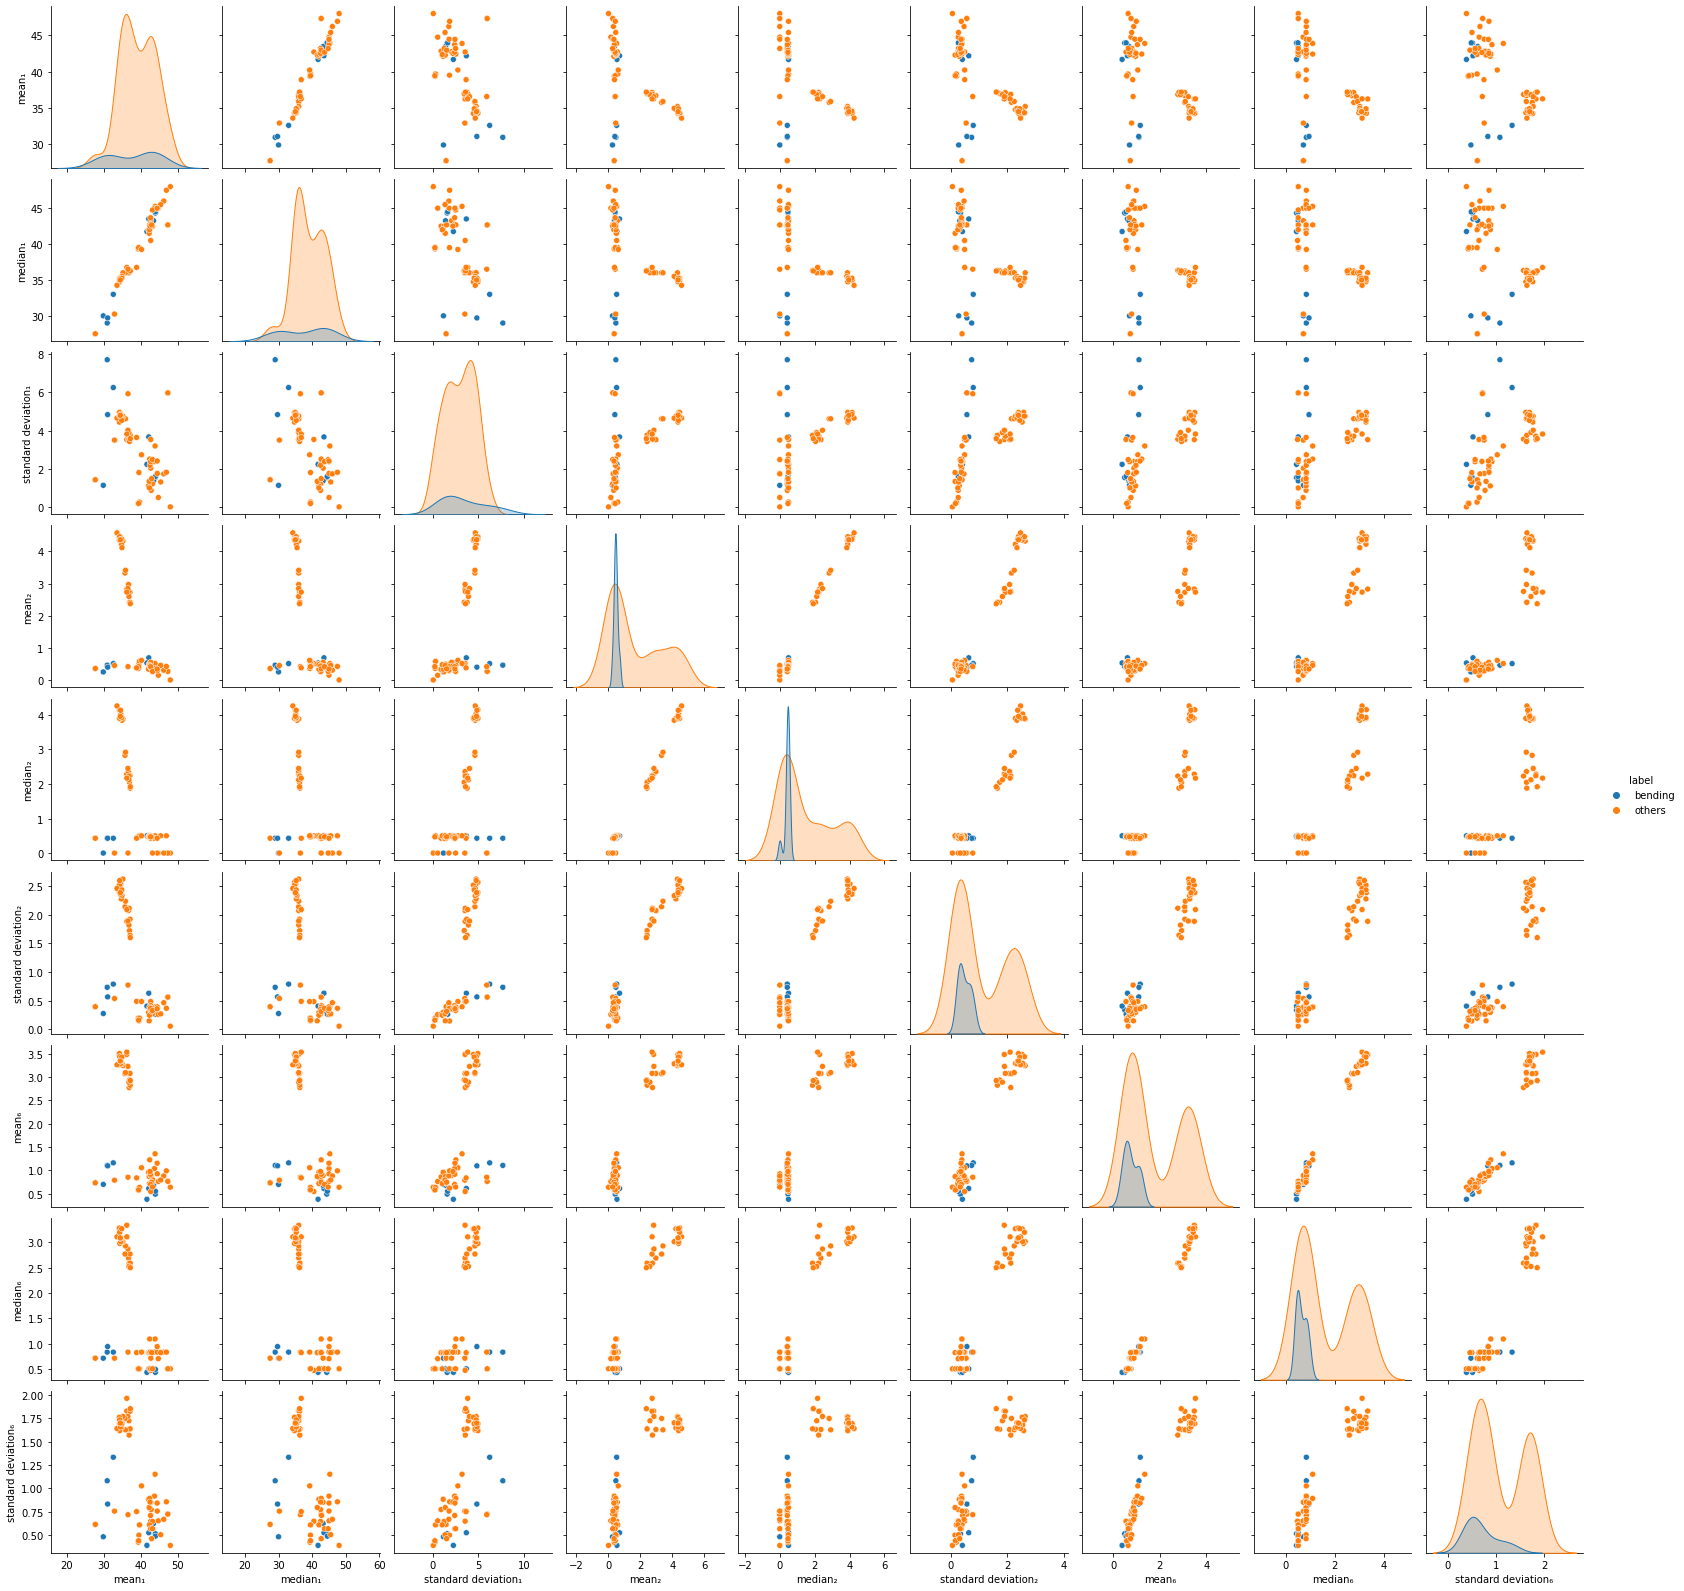

In [5]:
count = 0
features_df = pd.DataFrame()
feature_list = ['avg_rss12', 'var_rss12', 'var_rss23']
for feature in feature_list:
    count += 1
    if count==3: count = 6
    feature_df = pd.concat([train_df[feature].groupby(train_df['instance']).mean(), 
                            train_df[feature].groupby(train_df['instance']).median(), 
                            train_df[feature].groupby(train_df['instance']).std()], axis=1)
    feature_df.columns = ["mean"+str(count).translate(subscript), "median"+str(count).translate(subscript),
                          "standard deviation"+str(count).translate(subscript)]
    features_df = pd.concat([features_df, feature_df], axis=1)
label_list = ['bending']*9 + ['others']*(len(features_df)-9)
features_df['label'] = label_list

sns.pairplot(features_df, hue='label')

#### ii. 
Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 1(d)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 12. Do you see any considerable difference in the results with those of 1(d)i?

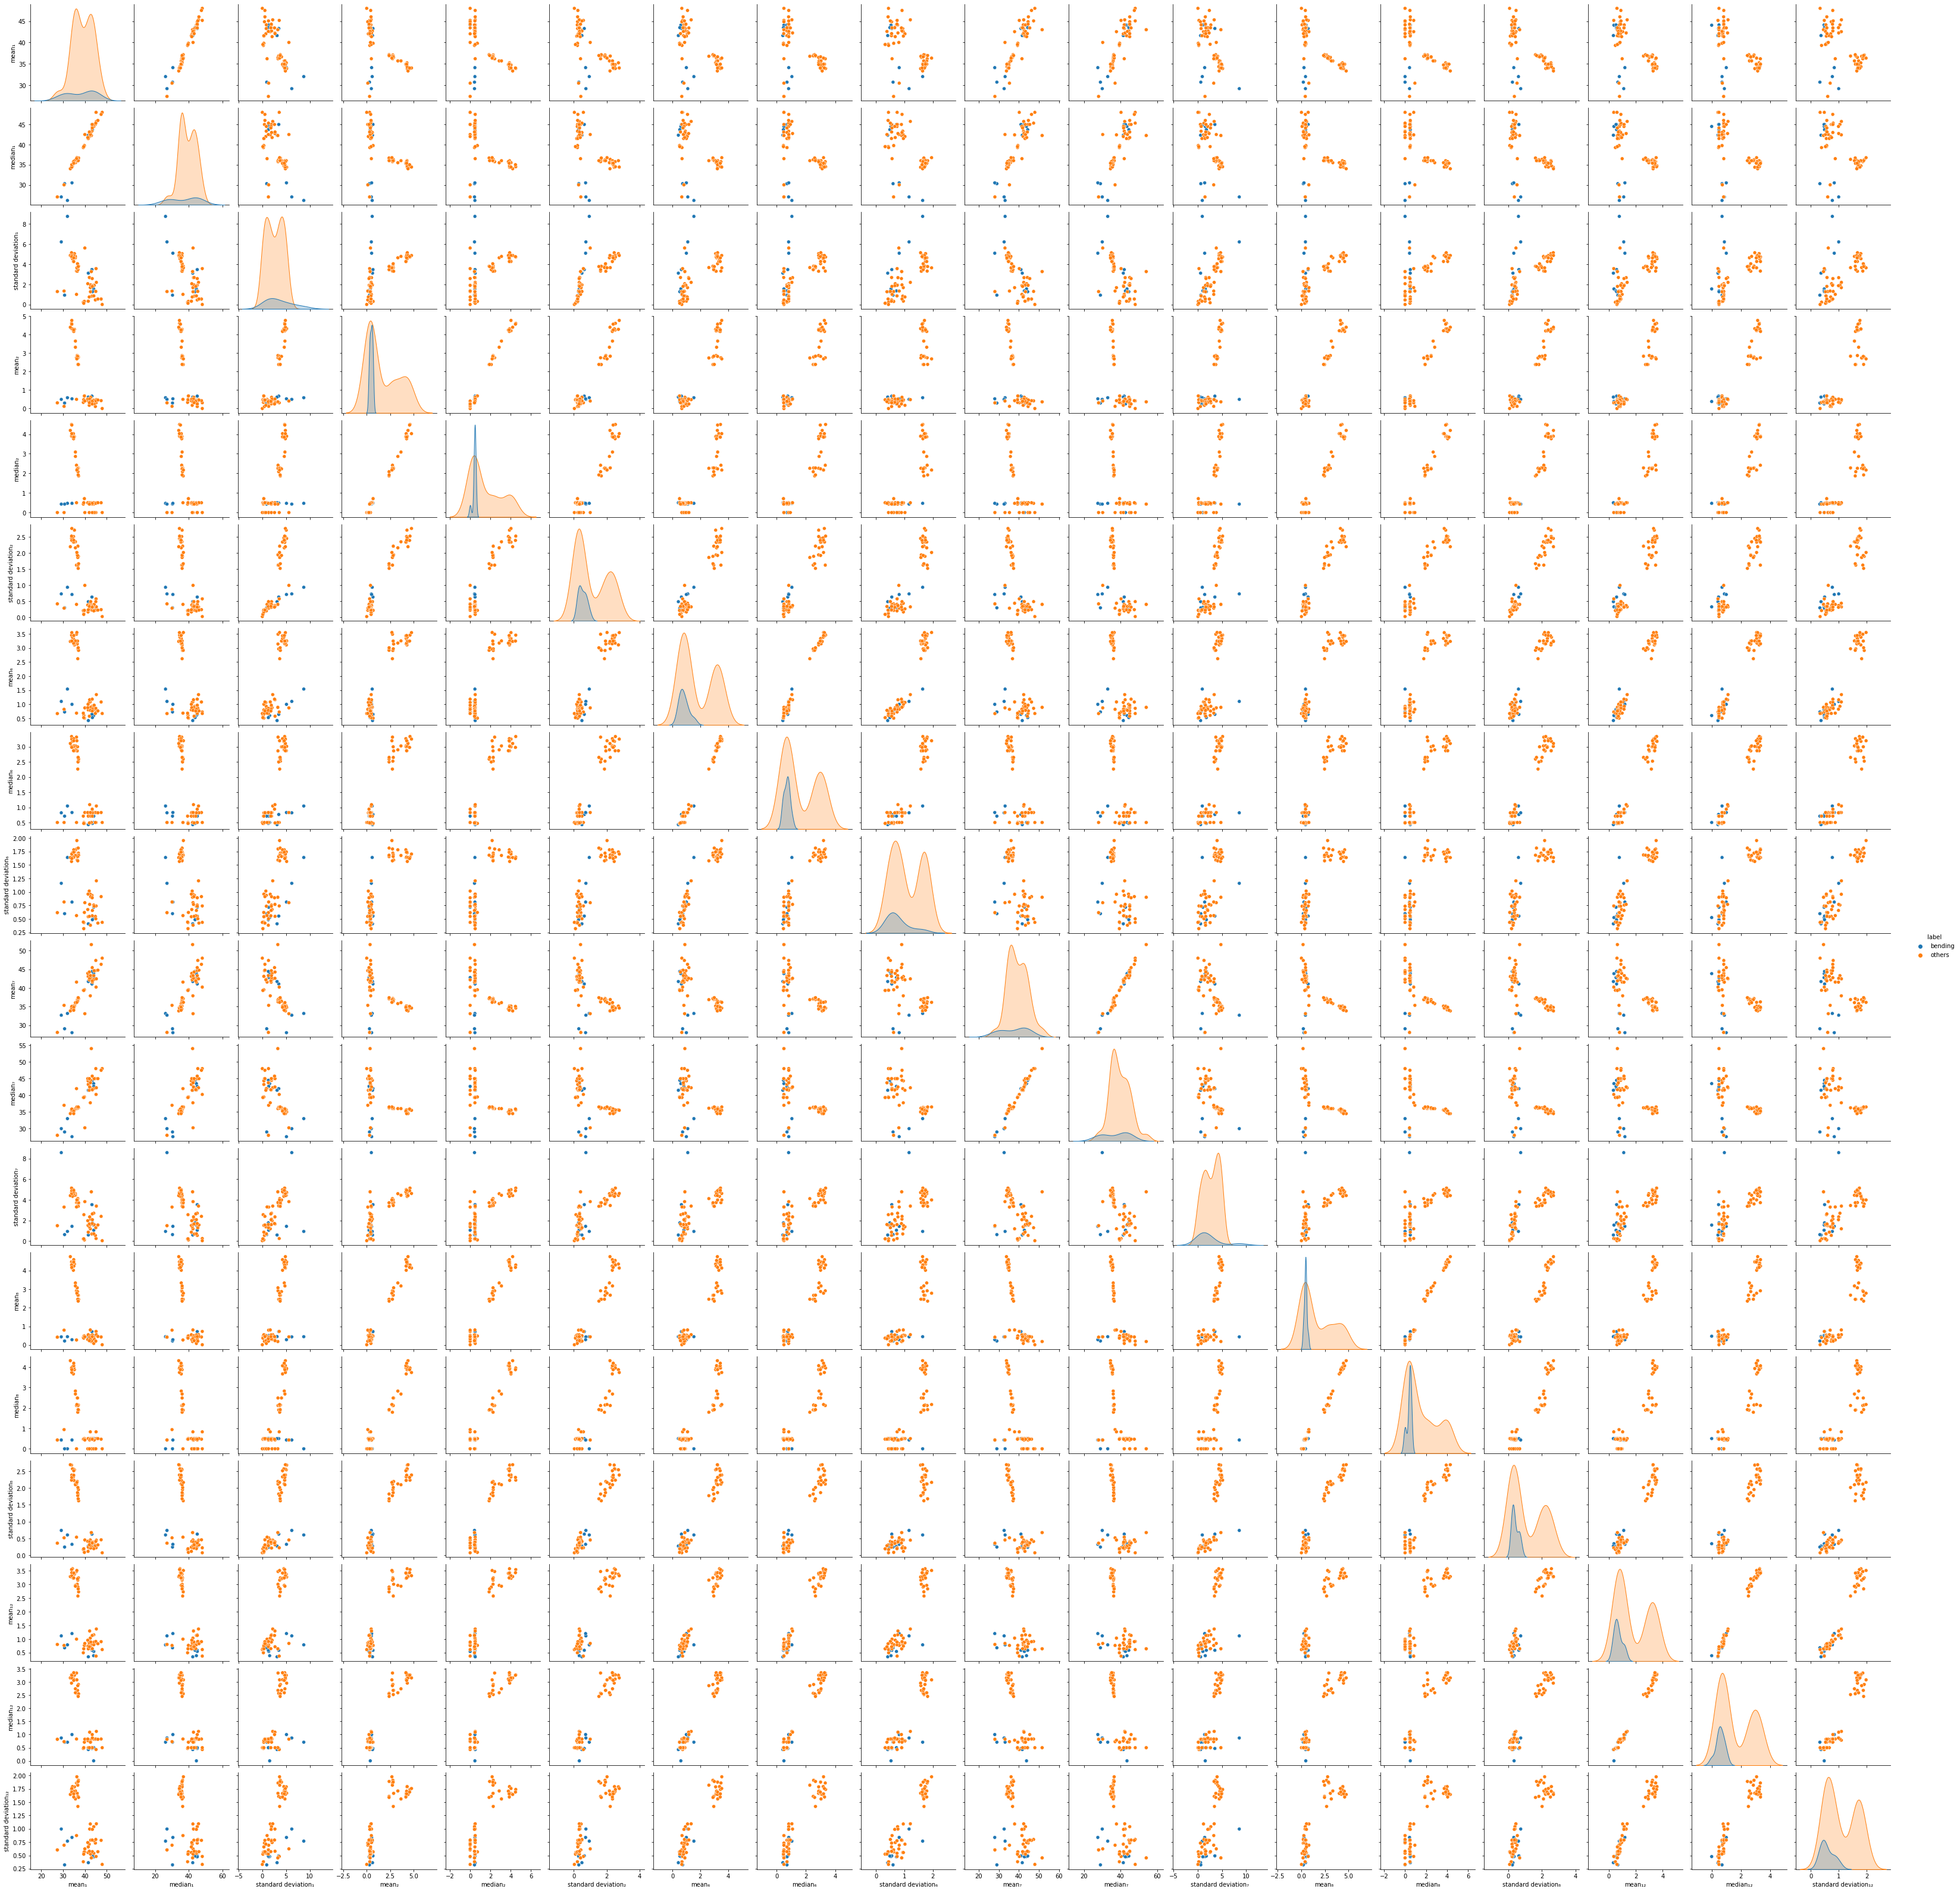

In [6]:
# Oops... Need to generate some functions to handle more complicated situations...
def get_features_df(raw_df, count):
    features_df = pd.DataFrame()
    feature_list = list(df.columns)[1:-3]
    for feature in feature_list:
        count += 1
        feature_df = pd.concat([raw_df[feature].groupby(raw_df['instance']).mean(), 
                                raw_df[feature].groupby(raw_df['instance']).median(), 
                                raw_df[feature].groupby(raw_df['instance']).std()], axis=1)
        feature_df.columns = ["mean"+str(count).translate(subscript), "median"+str(count).translate(subscript),
                              "standard deviation"+str(count).translate(subscript)]
        features_df = pd.concat([features_df, feature_df], axis=1)
    return features_df

def break_time_series(train_df, break_num):
    train_instance_num = len(list(train_df['instance'].unique()))
    break_instance_size = int(480/break_num)
    break_train_features_df = pd.DataFrame()
    for i in range(1, break_num+1):
        break_df = train_df.groupby('instance').apply(lambda x: x[break_instance_size*(i-1):break_instance_size*i])
        break_df.index = list(range(0, break_instance_size)) * train_instance_num
        break_features_df = get_features_df(break_df, count=6*(i-1))
        # print(break_features_df)
        break_train_features_df = pd.concat([break_train_features_df, break_features_df], axis=1)
    return break_train_features_df
        
def filter_features_df(features_df, time_series):
    requested_features = list()
    for index in time_series:
        requested_features.append('mean' + str(index).translate(subscript))
        requested_features.append('median' + str(index).translate(subscript))
        requested_features.append('standard deviation' + str(index).translate(subscript))
    filtered_features_df = pd.DataFrame(features_df, columns=requested_features)
    return filtered_features_df

features_df_bii = filter_features_df(break_time_series(train_df, 2), [1, 2, 6, 7, 8, 12])
label_list = ['bending']*9 + ['others']*(len(features_df_bii)-9)
features_df_bii['label'] = label_list

sns.pairplot(features_df_bii, hue='label')

**ANSWER**: No considerable difference. Just some little changes of positions of points.

#### iii. 

Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.

**ANSWER**:
* **RIGHT** WAY: Use backward selection using sklearn.feature selection. In this way, we do feature selection in CV and get the best features using RFE, which makes best use of validation. Then we refit the model with training set. Finally test on test set.
* **WRONG** WAY: Calculate p-values, prune parameters and refit. In this way, during your first fit, the model has already used the validation part of the training set, which will make later CV less accurate (i.e., lower the error).

In [7]:
max_l = 20
l_list = range(1, max_l+1)
rfe_list = list()
X_train_list = list()
y_train_list = list()
p_list = list()
cv_accuracy_list = list()
train_accuracy_list = list()
for l in l_list:
    break_train_df = break_time_series(train_df, l)
    label_list = ['bending']*9 + ['others']*(len(break_train_df)-9)
    break_train_df['label'] = label_list
    # change labels to 1/0
    break_train_df.replace('bending', 1, inplace=True)
    break_train_df.replace('others', 0, inplace=True)
    
    X_train = break_train_df.drop(['label'], axis=1)
    y_train = break_train_df['label']
    print("For l="+str(l)+"-"*100)
    # print(X_train[X_train.isnull().T.any()])
    
    # iii
    model = LogisticRegression(C=float('inf'), max_iter=10000)
    rfe = RFECV(estimator=model, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
    rfe = rfe.fit(X_train, y_train)
    rfe_list.append(rfe)
    best_model = rfe.estimator_ # the fitted estimator used to select features
    cv_accuracy = np.max(rfe.grid_scores_) # mean of cv scores of best model
    cv_accuracy_list.append(cv_accuracy)
    best_p = rfe.n_features_ # the number of selected features with cross-validation
    p_list.append(best_p)
    print("best pair: "+"{l="+str(l)+", p="+str(best_p)+"}")
    print("cv accuracy:", cv_accuracy)
    
    X_train = rfe.transform(X_train)
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    train_accuracy = best_model.score(X_train, y_train)
    train_accuracy_list.append(train_accuracy)
    print("train accuracy:", train_accuracy, "\n")

For l=1----------------------------------------------------------------------------------------------------
best pair: {l=1, p=8}
cv accuracy: 0.956043956043956
train accuracy: 1.0 

For l=2----------------------------------------------------------------------------------------------------
best pair: {l=2, p=4}
cv accuracy: 0.9714285714285715
train accuracy: 0.9565217391304348 

For l=3----------------------------------------------------------------------------------------------------
best pair: {l=3, p=1}
cv accuracy: 0.9428571428571428
train accuracy: 0.9710144927536232 

For l=4----------------------------------------------------------------------------------------------------
best pair: {l=4, p=60}
cv accuracy: 0.956043956043956
train accuracy: 1.0 

For l=5----------------------------------------------------------------------------------------------------
best pair: {l=5, p=2}
cv accuracy: 0.9571428571428571
train accuracy: 1.0 

For l=6--------------------------------------------

**ANSWER**: 

{l=1, p=8}, {l=4, p=60}, {l=5, p=2}, {l=6, p=5}, {l=8, p=58}, {l=9, p=12}, {l=10, p=77}, {l=11, p=2}, {l=12, p=53}, {l=13, p=29}, {l=14, p=42}, {l=15, p=28}, {l=16, p=130}, {l=17, p=84}, {l=18, p=187}, {l=19, p=123}, {l=20, p=233} all have train accuracy as 1.0.

{l=10, p=77}, {l=12, p=53}, {l=13, p=29}, {l=16, p=130}, {l=17, p=84}, {l=18, p=187}, {l=19, p=123}, {l=20, p=233} all have cv accuracy as 0.9857142857142858.

Based on these two metrics, {l=10, p=77}, {l=12, p=53}, {l=13, p=29}, {l=16, p=130}, {l=17, p=84}, {l=18, p=187}, {l=19, p=123}, {l=20, p=233} are equally best pairs.

#### iv.
Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

For {l=10, p=77}----------------------------------------------------------------------------------------------------
Confusion Matrix: 
 [[60  0]
 [ 0  9]] 

ROC and AUC:


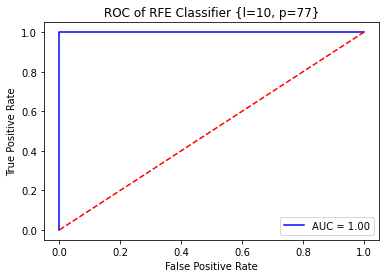

         Current function value: 0.000053
         Iterations: 15
         Function evaluations: 20
         Gradient evaluations: 20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0234        nan        nan        nan         nan         nan
x1             0.0925        nan        nan        nan         nan         nan
x2            -0.0283        nan        nan        nan         nan         nan
x3            -0.1056        nan        nan        nan         nan         nan
x4            -0.0912        nan        nan        nan         nan         nan
x5             0.3464        nan        nan        nan         nan         nan
x6             0.0428        nan        nan        nan         nan         nan
x7             0.7870        nan        nan        nan         nan         nan
x8             0.6586        nan        nan        nan         nan         n

/Users/pc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/pc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


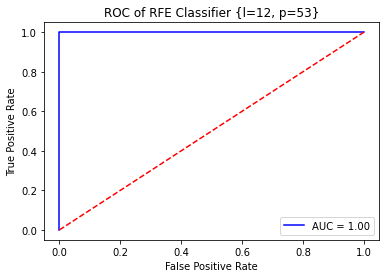

/Users/pc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000084
         Iterations: 15
         Function evaluations: 20
         Gradient evaluations: 20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0667   6.81e+04  -9.79e-07      1.000   -1.34e+05    1.34e+05
x1            -0.1120   5923.476  -1.89e-05      1.000   -1.16e+04    1.16e+04
x2            -0.2725   5107.300  -5.34e-05      1.000      -1e+04       1e+04
x3             0.3319   8517.167    3.9e-05      1.000   -1.67e+04    1.67e+04
x4             0.0530   7974.482   6.65e-06      1.000   -1.56e+04    1.56e+04
x5             1.0604   5378.421      0.000      1.000   -1.05e+04    1.05e+04
x6             0.6482   4397.640      0.000      1.000   -8618.568    8619.864
x7            -0.1421      4e+04  -3.56e-06      1.000   -7.83e+04    7.83e+04
x8             0.3923   2063.003      0.000      1.000   -4043.019    4043.8

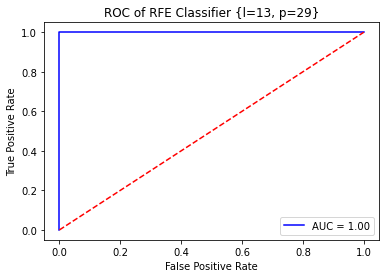

         Current function value: 0.000085
         Iterations: 15
         Function evaluations: 20
         Gradient evaluations: 20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0758   4987.446  -1.52e-05      1.000   -9775.290    9775.139
x1            -0.4178    265.295     -0.002      0.999    -520.386     519.550
x2             0.7273    677.020      0.001      0.999   -1326.208    1327.663
x3             0.6304    519.018      0.001      0.999   -1016.627    1017.887
x4             0.4189    629.548      0.001      0.999   -1233.473    1234.311
x5            -0.4595    599.695     -0.001      0.999   -1175.840    1174.921
x6             0.9912    768.698      0.001      0.999   -1505.629    1507.612
x7             0.4376    826.664      0.001      1.000   -1619.794    1620.669
x8            -0.5366    610.025     -0.001      0.999   -1196.163    1195.0

/Users/pc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


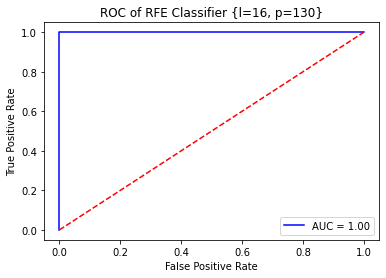

         Current function value: 0.000117
         Iterations: 15
         Function evaluations: 20
         Gradient evaluations: 20


/Users/pc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/pc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020        nan        nan        nan         nan         nan
x1             0.1307        nan        nan        nan         nan         nan
x2             0.0577        nan        nan        nan         nan         nan
x3             0.0491        nan        nan        nan         nan         nan
x4             0.0249        nan        nan        nan         nan         nan
x5             0.1869        nan        nan        nan         nan         nan
x6            -0.0978        nan        nan        nan         nan         nan
x7             0.0273        nan        nan        nan         nan         nan
x8            -0.0413        nan        nan        nan         nan         nan
x9             0.2259        nan        nan        nan         nan         nan
x10            0.0566        nan        nan        n

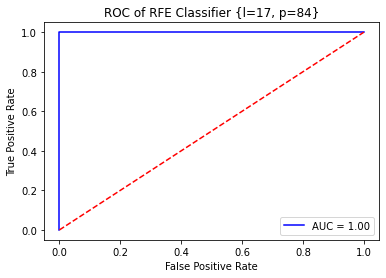

         Current function value: 0.000212
         Iterations: 15
         Function evaluations: 20
         Gradient evaluations: 20


/Users/pc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/pc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0155        nan        nan        nan         nan         nan
x1            -0.0220        nan        nan        nan         nan         nan
x2             0.0012        nan        nan        nan         nan         nan
x3             0.0002        nan        nan        nan         nan         nan
x4            -0.0547        nan        nan        nan         nan         nan
x5             0.1840        nan        nan        nan         nan         nan
x6            -0.0511        nan        nan        nan         nan         nan
x7            -0.0084        nan        nan        nan         nan         nan
x8            -0.0095        nan        nan        nan         nan         nan
x9             0.0096        nan        nan        nan         nan         nan
x10            0.5147        nan        nan        n

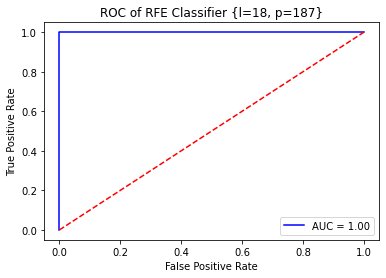

         Current function value: 0.000137
         Iterations: 15
         Function evaluations: 20
         Gradient evaluations: 20


/Users/pc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/pc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0051        nan        nan        nan         nan         nan
x1             0.0860        nan        nan        nan         nan         nan
x2             0.1108        nan        nan        nan         nan         nan
x3             0.0297        nan        nan        nan         nan         nan
x4            -0.0228        nan        nan        nan         nan         nan
x5            -0.0010        nan        nan        nan         nan         nan
x6             0.0169        nan        nan        nan         nan         nan
x7             0.0105        nan        nan        nan         nan         nan
x8             0.0864        nan        nan        nan         nan         nan
x9             0.0625        nan        nan        nan         nan         nan
x10            0.0734        nan        nan        n

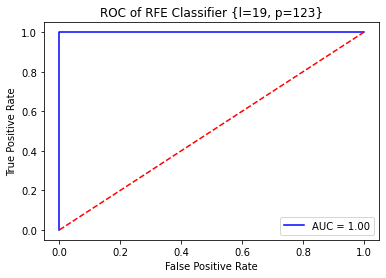

         Current function value: 0.000110
         Iterations: 15
         Function evaluations: 20
         Gradient evaluations: 20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0045        nan        nan        nan         nan         nan
x1            -0.0633        nan        nan        nan         nan         nan
x2             0.0215        nan        nan        nan         nan         nan
x3             0.0233        nan        nan        nan         nan         nan
x4             0.1420        nan        nan        nan         nan         nan
x5            -0.0971        nan        nan        nan         nan         nan
x6            -0.0757        nan        nan        nan         nan         nan
x7             0.0970        nan        nan        nan         nan         nan
x8            -0.2010        nan        nan        nan         nan         n

/Users/pc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/pc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


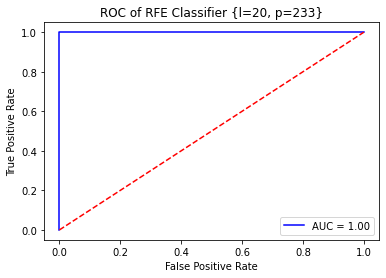

         Current function value: 0.000526
         Iterations: 15
         Function evaluations: 20
         Gradient evaluations: 20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021        nan        nan        nan         nan         nan
x1             0.0520        nan        nan        nan         nan         nan
x2             0.0541        nan        nan        nan         nan         nan
x3             0.0107        nan        nan        nan         nan         nan
x4             0.0051        nan        nan        nan         nan         nan
x5             0.0235        nan        nan        nan         nan         nan
x6             0.0188        nan        nan        nan         nan         nan
x7             0.1273        nan        nan        nan         nan         nan
x8             0.0177        nan        nan        nan         nan         n

/Users/pc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/pc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
# {l=1, p=8}, {l=4, p=60}, {l=5, p=2}, {l=6, p=5}, {l=8, p=58}, {l=9, p=12}, {l=10, p=77}, {l=11, p=2}, {l=12, p=53}, 
# {l=13, p=29}, {l=14, p=42}, {l=15, p=28}, {l=16, p=130}, {l=17, p=84}, {l=18, p=187}, {l=19, p=123}, {l=20, p=233}
# all have train accuracy as 1.0.
# best_l_list = [1, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] # decided by train_accuracy

# {l=10, p=77}, {l=12, p=53}, {l=13, p=29}, {l=16, p=130}, {l=17, p=84}, {l=18, p=187}, {l=19, p=123}, {l=20, p=233}
# all have cv accuracy as 0.9857142857142858.

# I will show all the best pairs with highest train_accuracy and cv accuracy.

best_l_list = [10, 12, 13, 16, 17, 18, 19, 20]

for l in best_l_list:
    print('For {l=' + str(l) + ', p=' + str(p_list[l-1]) +'}' + '-'*100)
    
    best_rfe = rfe_list[l-1]
    best_classifier = best_rfe.estimator_
    X_train = X_train_list[l-1]
    y_train = y_train_list[l-1]
    y_predict = best_classifier.predict(X_train)
    c_m = confusion_matrix(y_train, y_predict)
    print('Confusion Matrix: \n', c_m, '\n')

    y_predict_proba = best_classifier.predict_proba(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, y_predict_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    print('ROC and AUC:')
    plt.title('ROC of RFE Classifier {l=' + str(l) + ', p=' + str(p_list[l-1]) +'}')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    # sklearn LogisticRegression does not have a built in method to calculate p-values
    # instead, use sm.Logit()
    X_train_constant = sm.add_constant(X_train)
    logit_model = sm.Logit(y_train, X_train_constant)
    result = logit_model.fit(method='bfgs', maxiter=15)
    print(result.summary().tables[1])
    print('\n')

#### v. 

Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [9]:
max_l = 20
l_list = range(1, max_l+1)
test_accuracy_list = list()
test_auc_list = list()

for l in l_list:
    break_test_df = break_time_series(test_df, l)
    label_list = ['bending']*4 + ['others']*(len(break_test_df)-4)
    break_test_df['label'] = label_list
    # change labels to 1/0
    break_test_df.replace('bending', 1, inplace=True)
    break_test_df.replace('others', 0, inplace=True)
    
    X_test = break_test_df.drop(['label'], axis=1)
    y_test = break_test_df['label']
    
    rfe = rfe_list[l-1]
    best_model = rfe.estimator_
    X_test = rfe.transform(X_test)
    test_accuracy = best_model.score(X_test, y_test)
    test_accuracy_list.append(test_accuracy)
    
    print('For {l=' + str(l) + ', p=' + str(p_list[l-1]) +'}' + '-'*100)
    print("cv accuracy:", str(cv_accuracy_list[l-1]))
    print("train accuracy:", str(train_accuracy_list[l-1]))
    print("test accuracy:", test_accuracy, "\n")
    
    # Calculate AUC on train set for eii to compare
    y_predict_proba = best_model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    test_auc_list.append(roc_auc)

For {l=1, p=8}----------------------------------------------------------------------------------------------------
cv accuracy: 0.956043956043956
train accuracy: 1.0
test accuracy: 1.0 

For {l=2, p=4}----------------------------------------------------------------------------------------------------
cv accuracy: 0.9714285714285715
train accuracy: 0.9565217391304348
test accuracy: 0.8421052631578947 

For {l=3, p=1}----------------------------------------------------------------------------------------------------
cv accuracy: 0.9428571428571428
train accuracy: 0.9710144927536232
test accuracy: 0.8421052631578947 

For {l=4, p=60}----------------------------------------------------------------------------------------------------
cv accuracy: 0.956043956043956
train accuracy: 1.0
test accuracy: 1.0 

For {l=5, p=2}----------------------------------------------------------------------------------------------------
cv accuracy: 0.9571428571428571
train accuracy: 1.0
test accuracy: 1.0 

F

**ANSWER**: In most cases, train accuracy and test accuracy are both 1.0, while the max cv accuracy is around (9.4, 9.9). For {l=2, p=4}, {l=3, p=1}, {l=7, p=1}, and {l=9, p=12}, test accuracy is lower than max cv accuracy and train accuracy.

#### vi. 
Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

**ANSWER**: Yes, I think they well-separated to cause instability. The p-values of parameters are very close to 1 and std errors are very high. For many pairs, the summary() even returns a bundle of nan. They seem like signs of well-separated classes to me.

#### vii.
From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

**ANSWER**: Yes. There are 60 instances of other activies and only 9 instances of bending, which would cause class imbalance. I have already applied cv=StratifiedKFold(5) in (d)iii, which make use of stratification, which is a process of arranging data to ensure that each fold is representative of all strata of the data. This can help ensure each class is (approximately) equally represented across each test fold.

**Citation**: https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation

According to TA, in this part, I will do down sampling to make control/case ratio to be **3:1**. 

For l=10----------------------------------------------------------------------------------------------------
New best pair: {l=10, p=4} 

Confusion Matrix: 
 [[27  0]
 [ 0  9]] 

ROC and AUC:


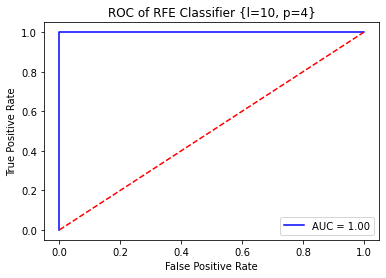



For l=12----------------------------------------------------------------------------------------------------
New best pair: {l=12, p=17} 

Confusion Matrix: 
 [[27  0]
 [ 0  9]] 

ROC and AUC:


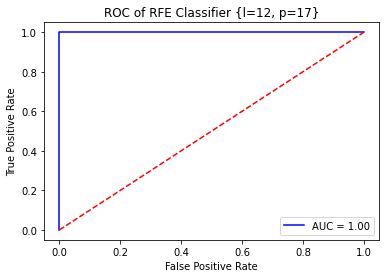



For l=13----------------------------------------------------------------------------------------------------
New best pair: {l=13, p=8} 

Confusion Matrix: 
 [[27  0]
 [ 0  9]] 

ROC and AUC:


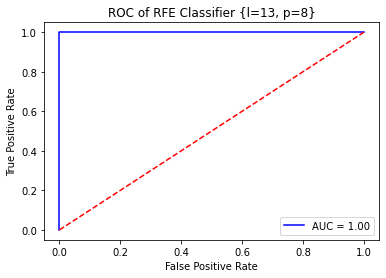



For l=16----------------------------------------------------------------------------------------------------
New best pair: {l=16, p=3} 

Confusion Matrix: 
 [[27  0]
 [ 0  9]] 

ROC and AUC:


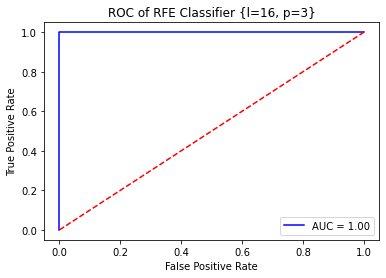



For l=17----------------------------------------------------------------------------------------------------
New best pair: {l=17, p=2} 

Confusion Matrix: 
 [[27  0]
 [ 0  9]] 

ROC and AUC:


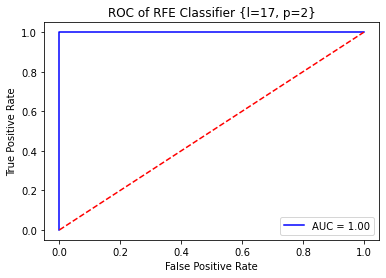



For l=18----------------------------------------------------------------------------------------------------
New best pair: {l=18, p=13} 

Confusion Matrix: 
 [[27  0]
 [ 0  9]] 

ROC and AUC:


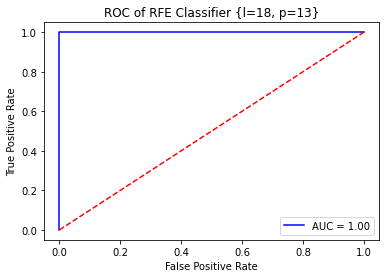



For l=19----------------------------------------------------------------------------------------------------
New best pair: {l=19, p=2} 

Confusion Matrix: 
 [[27  0]
 [ 0  9]] 

ROC and AUC:


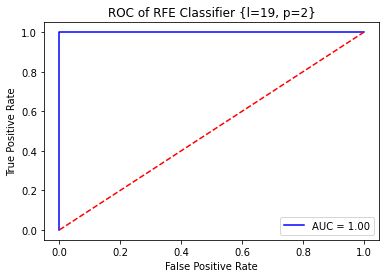



For l=20----------------------------------------------------------------------------------------------------
New best pair: {l=20, p=12} 

Confusion Matrix: 
 [[27  0]
 [ 0  9]] 

ROC and AUC:


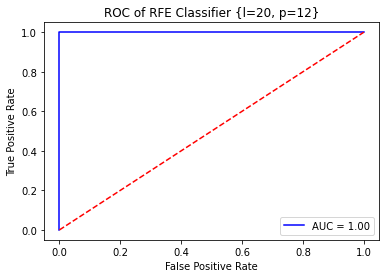

In [10]:
best_l_list = [10, 12, 13, 16, 17, 18, 19, 20]

for l in best_l_list:
    print('For l=' + str(l) + '-'*100)
    
    break_train_df = break_time_series(train_df, l)
    label_list = ['bending']*9 + ['others']*(len(break_train_df)-9)
    break_train_df['label'] = label_list
    # change labels to 1/0
    break_train_df.replace('bending', 1, inplace=True)
    break_train_df.replace('others', 0, inplace=True)
    
    # Do down sampling (make number of controls be 27)
    bending_df = break_train_df[break_train_df['label']==1]
    others_df = break_train_df[break_train_df['label']==0]
    others_df = others_df.sample(n=27, random_state=1)
    break_train_df = pd.concat([bending_df, others_df], axis=0)
    
    X_train = break_train_df.drop(['label'], axis=1)
    y_train = break_train_df['label']
    
    model = LogisticRegression(C=float('inf'), max_iter=10000)
    rfe = RFECV(estimator=model, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
    rfe = rfe.fit(X_train, y_train)
    best_model = rfe.estimator_ # the fitted estimator used to select features
    cv_accuracy = np.max(rfe.grid_scores_) # mean of cv scores of best model
    best_p = rfe.n_features_ # the number of selected features with cross-validation
    print("New best pair: "+"{l="+str(l)+", p="+str(best_p)+"}", "\n")
    
    X_train = rfe.transform(X_train)
    
    y_predict = best_model.predict(X_train)
    c_m = confusion_matrix(y_train, y_predict)
    print('Confusion Matrix: \n', c_m, '\n')

    y_predict_proba = best_model.predict_proba(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, y_predict_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    print('ROC and AUC:')
    plt.title('ROC of RFE Classifier {l=' + str(l) + ', p=' + str(best_p) +'}')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('\n')

### (e) Binary Classification Using L1-penalized logistic regression

#### i.
Repeat 1(d)iii using L1-penalized logistic regression, i.e. instead of using p-values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [ ]:
max_l = 20
l_list = range(1, max_l+1)
l1_test_accuracy_list = list()
l1_test_auc_list = list()
for l in l_list:
    print("For l="+str(l)+"-"*100)
    
    break_train_df = break_time_series(train_df, l)
    label_list = ['bending']*9 + ['others']*(len(break_train_df)-9)
    break_train_df['label'] = label_list
    # change labels to 1/0
    break_train_df.replace('bending', 1, inplace=True)
    break_train_df.replace('others', 0, inplace=True)
    X_train = break_train_df.drop(['label'], axis=1)
    y_train = break_train_df['label']
    
    break_test_df = break_time_series(test_df, l)
    label_list = ['bending']*4 + ['others']*(len(break_test_df)-4)
    break_test_df['label'] = label_list
    # change labels to 1/0
    break_test_df.replace('bending', 1, inplace=True)
    break_test_df.replace('others', 0, inplace=True)
    X_test = break_test_df.drop(['label'], axis=1)
    y_test = break_test_df['label']
    
    # ei: using liblinear as solver
    model = LogisticRegression(penalty='l1', solver='liblinear')
    C_range = 10.**np.arange(-5, 5)
    parameters = {'logisticregression__C': C_range}
    
    # Standardize data
    pipe = make_pipeline(preprocessing.StandardScaler(), model)
    # Do cv for both l and C
    grid_model = GridSearchCV(estimator=pipe, param_grid=parameters, scoring='accuracy',
                              cv=StratifiedKFold(5), n_jobs=-1)
    grid_model.fit(X_train, y_train)
    
    best_model = grid_model.best_estimator_ # estimator which gave highest score
    cv_accuracy = grid_model.best_score_ # mean of cv scores of best estimator
    best_C = list(grid_model.best_params_.values())[0] # best C
    print("best pair: "+"{l="+str(l)+", C="+str(best_C)+"}")
    print("cv accuracy:", cv_accuracy)
    
    train_accuracy = best_model.score(X_train, y_train)
    print("train accuracy:", train_accuracy)
    
    test_accuracy = best_model.score(X_test, y_test)
    l1_test_accuracy_list.append(test_accuracy)
    print("test accuracy:", test_accuracy)
    
    y_predict_proba = best_model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    l1_test_auc_list.append(roc_auc)
    print("test AUC:", roc_auc, "\n")

For l=1----------------------------------------------------------------------------------------------------
best pair: {l=1, C=1.0}
cv accuracy: 0.9274725274725275
train accuracy: 0.9710144927536232
test accuracy: 1.0
test AUC: 1.0 

For l=2----------------------------------------------------------------------------------------------------
best pair: {l=2, C=10.0}
cv accuracy: 0.9428571428571428
train accuracy: 1.0
test accuracy: 0.9473684210526315
test AUC: 0.9166666666666667 

For l=3----------------------------------------------------------------------------------------------------
best pair: {l=3, C=1.0}
cv accuracy: 0.9571428571428573
train accuracy: 1.0
test accuracy: 0.9473684210526315
test AUC: 0.9500000000000001 

For l=4----------------------------------------------------------------------------------------------------
best pair: {l=4, C=1.0}
cv accuracy: 0.9714285714285715
train accuracy: 1.0
test accuracy: 0.9473684210526315
test AUC: 0.9500000000000001 

For l=5-----------

**ANSWER**: If we choose best pair merely based on cv accuracy, according to the data above, the best pair is **{l=18, C=10.0}** with highest cv accuracy, which is 0.9857142857142858.

#### ii. 
Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

In [ ]:
max_l = 20
result_df = pd.DataFrame()
result_df['RFE_test_accuracy'] = test_accuracy_list
result_df['L1_test_accuracy'] = l1_test_accuracy_list
result_df['RFE_test_AUC'] = test_auc_list
result_df['L1_test_AUC'] = l1_test_auc_list
result_df.index = list(range(1, max_l+1))
result_df.index.names = ['l']
result_df

**ANSWER**: 

According to the results on test set, in most cases, variable selection using p-values has both higher test accuracy and test AUC than L1-penalized, so **variable selection using p-values performs better** in this case. 

As for easiness, L1-penalized could do feature transformation automatically so we do not need to transform features like using p-values. However, we need to do data standardization for L1-penalized. To sum up, they have their own advantages respectively, but I think variable selection using p-values is a little bit easier since feature transformation is easier than data standardization.

### (f) Multi-class Classification (The Realistic Case)

#### i.
Find the best l in the same way as you found it in 1(e)i to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [ ]:
max_l = 20
l_list = range(1, max_l+1)
m_class_test_error_list = list()
m_class_test_auc_list = list()
for l in l_list:
    print("For l="+str(l)+"-"*100)
    
    break_train_df = break_time_series(train_df, l)
    label_list = ['bending']*9 + ['cycling']*12 + ['lying']*12 + ['sitting']*12 + ['standing']*12 + ['walking']*12
    break_train_df['label'] = label_list
    X_train = break_train_df.drop(['label'], axis=1)
    y_train = pd.Categorical(break_train_df['label']).codes
    
    break_test_df = break_time_series(test_df, l)
    label_list = ['bending']*4 + ['cycling']*3 + ['lying']*3 + ['sitting']*3 + ['standing']*3 + ['walking']*3
    break_test_df['label'] = label_list
    X_test = break_test_df.drop(['label'], axis=1)
    y_test = pd.Categorical(break_test_df['label']).codes
    
    # ei: using liblinear as solver
    model = LogisticRegression(penalty='l1', solver='liblinear')
    C_range = 10.**np.arange(-5, 5)
    parameters = {'logisticregression__C': C_range}
    
    # Standardize data
    pipe = make_pipeline(preprocessing.StandardScaler(), model)
    # Do cv for both l and C
    grid_model = GridSearchCV(estimator=pipe, param_grid=parameters, scoring='accuracy',
                              cv=StratifiedKFold(5), n_jobs=-1)
    grid_model.fit(X_train, y_train)
    
    best_model = grid_model.best_estimator_ # estimator which gave highest score
    cv_accuracy = grid_model.best_score_ # mean of cv scores of best estimator
    best_C = list(grid_model.best_params_.values())[0] # best C
    print("best pair: "+"{l="+str(l)+", C="+str(best_C)+"}")
    print("cv accuracy:", cv_accuracy)
    
    train_accuracy = best_model.score(X_train, y_train)
    print("train accuracy:", train_accuracy)
    
    test_accuracy = best_model.score(X_test, y_test)
    m_class_test_error_list.append(1-test_accuracy)
    print("test accuracy:", test_accuracy, "|", "test error:", (1-test_accuracy))
    
    # Get confusion matrix and ROC&AOC for multiclass classification
    y_predict_proba = best_model.predict_proba(X_test)
    n_class = len(list(np.unique(y_test)))
    y_one_hot = preprocessing.label_binarize(y_test, np.arange(n_class))
    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(), y_predict_proba.ravel())
    labels=list(np.unique(y_test))
    roc_auc = auc(fpr, tpr)
    m_class_test_auc_list.append(roc_auc)
    
    y_predict = best_model.predict(X_test)
    c_m = confusion_matrix(y_test, y_predict, labels=labels)
    print('Confusion Matrix: \n', c_m)
    
    print('ROC and AUC:')
    plt.title('ROC of L1 Classifier {l=' + str(l) + ', C=' + str(best_C) +'}')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('\n')

**ANSWER**: If we choose best pair merely based on cv accuracy, according to the data above, the best pair is **{l=12, C=10.0}** with highest cv accuracy, which is 0.856043956043956.

#### ii. 
Repeat 1(f)i using a Naive Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

In [ ]:
# Gaussian
max_l = 20
l_list = range(1, max_l+1)
Gaussian_test_error_list = list()
Gaussian_test_auc_list = list()
for l in l_list:
    print("For l="+str(l)+"-"*100)
    
    break_train_df = break_time_series(train_df, l)
    label_list = ['bending']*9 + ['cycling']*12 + ['lying']*12 + ['sitting']*12 + ['standing']*12 + ['walking']*12
    break_train_df['label'] = label_list
    X_train = break_train_df.drop(['label'], axis=1)
    y_train = pd.Categorical(break_train_df['label']).codes
    
    break_test_df = break_time_series(test_df, l)
    label_list = ['bending']*4 + ['cycling']*3 + ['lying']*3 + ['sitting']*3 + ['standing']*3 + ['walking']*3
    break_test_df['label'] = label_list
    X_test = break_test_df.drop(['label'], axis=1)
    y_test = pd.Categorical(break_test_df['label']).codes
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    
    train_accuracy = clf.score(X_train, y_train)
    print("train accuracy:", train_accuracy)
    
    test_accuracy = clf.score(X_test, y_test)
    Gaussian_test_error_list.append(1-test_accuracy)
    print("test accuracy:", test_accuracy, "|", "test error:", (1-test_accuracy))
    
    # Get confusion matrix and ROC&AOC for multiclass classification
    y_predict_proba = clf.predict_proba(X_test)
    n_class = len(list(np.unique(y_test)))
    y_one_hot = preprocessing.label_binarize(y_test, np.arange(n_class))
    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(), y_predict_proba.ravel())
    labels=list(np.unique(y_test))
    roc_auc = auc(fpr, tpr)
    Gaussian_test_auc_list.append(roc_auc)
    
    y_predict = clf.predict(X_test)
    c_m = confusion_matrix(y_test, y_predict, labels=labels)
    print('Confusion Matrix: \n', c_m)
    
    print('ROC and AUC:')
    plt.title('ROC of L1 Classifier {l=' + str(l) + ', C=' + str(best_C) +'}')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('\n')

In [ ]:
# Multinomial
max_l = 20
l_list = range(1, max_l+1)
Multinomial_test_error_list = list()
Multinomial_test_auc_list = list()
for l in l_list:
    print("For l="+str(l)+"-"*100)
    
    break_train_df = break_time_series(train_df, l)
    label_list = ['bending']*9 + ['cycling']*12 + ['lying']*12 + ['sitting']*12 + ['standing']*12 + ['walking']*12
    break_train_df['label'] = label_list
    X_train = break_train_df.drop(['label'], axis=1)
    y_train = pd.Categorical(break_train_df['label']).codes
    
    break_test_df = break_time_series(test_df, l)
    label_list = ['bending']*4 + ['cycling']*3 + ['lying']*3 + ['sitting']*3 + ['standing']*3 + ['walking']*3
    break_test_df['label'] = label_list
    X_test = break_test_df.drop(['label'], axis=1)
    y_test = pd.Categorical(break_test_df['label']).codes
    
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    
    train_accuracy = clf.score(X_train, y_train)
    print("train accuracy:", train_accuracy)
    
    test_accuracy = clf.score(X_test, y_test)
    Multinomial_test_error_list.append(1-test_accuracy)
    print("test accuracy:", test_accuracy, "|", "test error:", (1-test_accuracy))
    
    # Get confusion matrix and ROC&AOC for multiclass classification
    y_predict_proba = clf.predict_proba(X_test)
    n_class = len(list(np.unique(y_test)))
    y_one_hot = preprocessing.label_binarize(y_test, np.arange(n_class))
    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(), y_predict_proba.ravel())
    labels=list(np.unique(y_test))
    roc_auc = auc(fpr, tpr)
    Multinomial_test_auc_list.append(roc_auc)
    
    y_predict = clf.predict(X_test)
    c_m = confusion_matrix(y_test, y_predict, labels=labels)
    print('Confusion Matrix: \n', c_m)
    
    print('ROC and AUC:')
    plt.title('ROC of L1 Classifier {l=' + str(l) + ', C=' + str(best_C) +'}')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('\n')

In [ ]:
max_l = 20
result_df = pd.DataFrame()
result_df['GaussianNB_test_error'] = Gaussian_test_error_list
result_df['MultinomialNB_test_error'] = Multinomial_test_error_list
result_df['GaussianNB_test_AUC'] = Gaussian_test_auc_list
result_df['MultinomialNB_test_AUC'] = Multinomial_test_auc_list
result_df.index = list(range(1, max_l+1))
result_df.index.names = ['l']
result_df

**ANSWER**: Generally, MultinomialNB has lower test error and higher test AUC, so it performs better than GaussianNB.

#### iii. 
Which method is better for multi-class classification in this problem?

In [ ]:
max_l = 20
result_df = pd.DataFrame()
result_df['L1_mc_test_error'] = m_class_test_error_list
result_df['GaussianNB_test_error'] = Gaussian_test_error_list
result_df['MultinomialNB_test_error'] = Multinomial_test_error_list
result_df['L1_mc_test_AUC'] = m_class_test_auc_list
result_df['GaussianNB_test_AUC'] = Gaussian_test_auc_list
result_df['MultinomialNB_test_AUC'] = Multinomial_test_auc_list
result_df.index = list(range(1, max_l+1))
result_df.index.names = ['l']
result_df

**ANSWER**: Considering all three method, MultinomialNB still has lowest test error and highest test AUC. So **MultinomialNB is the best in this problem**.

## 2. ISLR 3.7.4

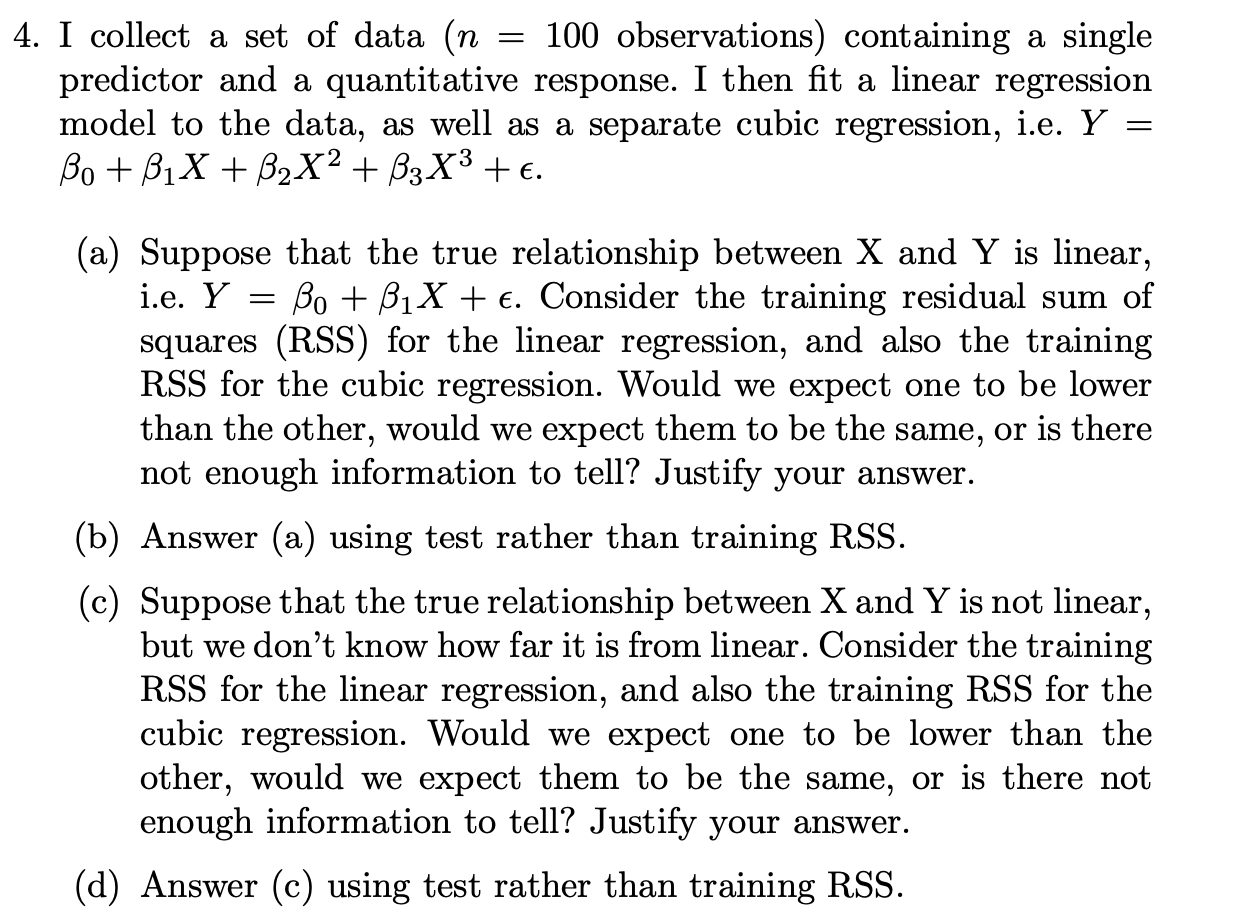

### (a)

**ANSWER**: I think the **cubric regression will have lower RSS**. Although the true relationship is linear, considering that we have small size of data and cubric regression is more flexible to fit data tightly than linear regression, there is a large chance that cubric regression has lower RSS.

### (b)

**ANSWER**: I think **linear regression will have lower RSS**. That is because the true relationship is linear. Though cubric regression may perform well in training set because of overfitting, it will lose its advantage in test set.

### (c)

**ANSWER**: I think **cubric regression will have lower RSS**. Still, cubric regression is more flexible to follow training data closely than linear regression, not to mention that the true relationship is not linear now.

### (d)

**ANSWER**: We **cannot make a conclusion** in this case. Depending on the non-linear degree, either model has a chance to have lower RSS. If the true relationship is more similar to linear, linear regression may have lower RSS. Otherwise, cubric regression will have lower RSS if the true relationship is closer to cubric.

## 3. ISLR, 4.8.3

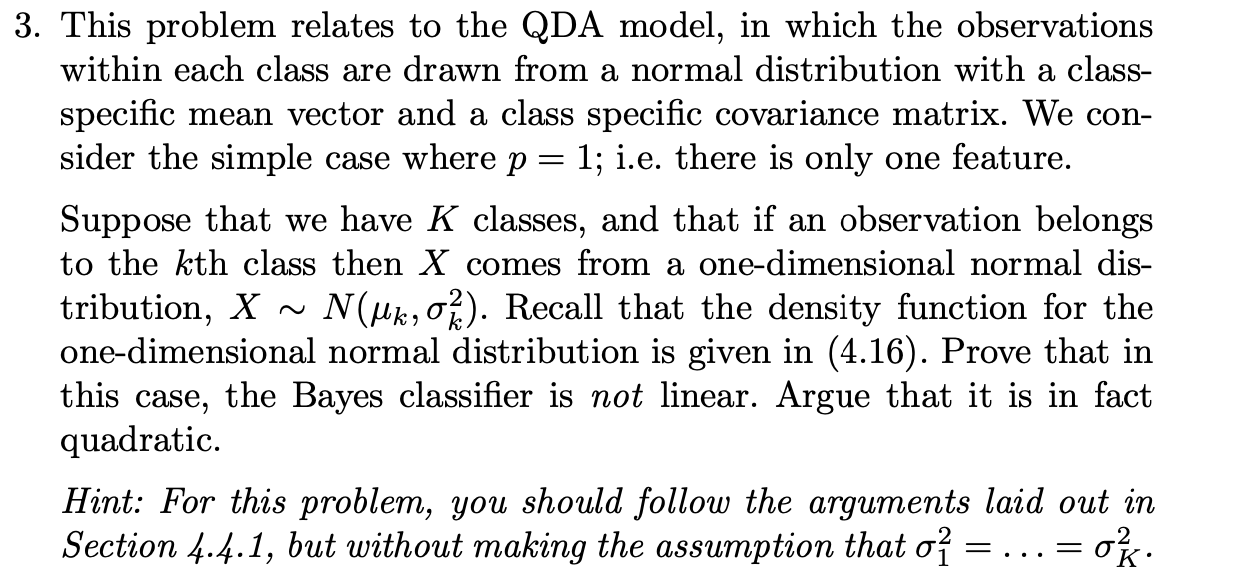

**ANSWER**:

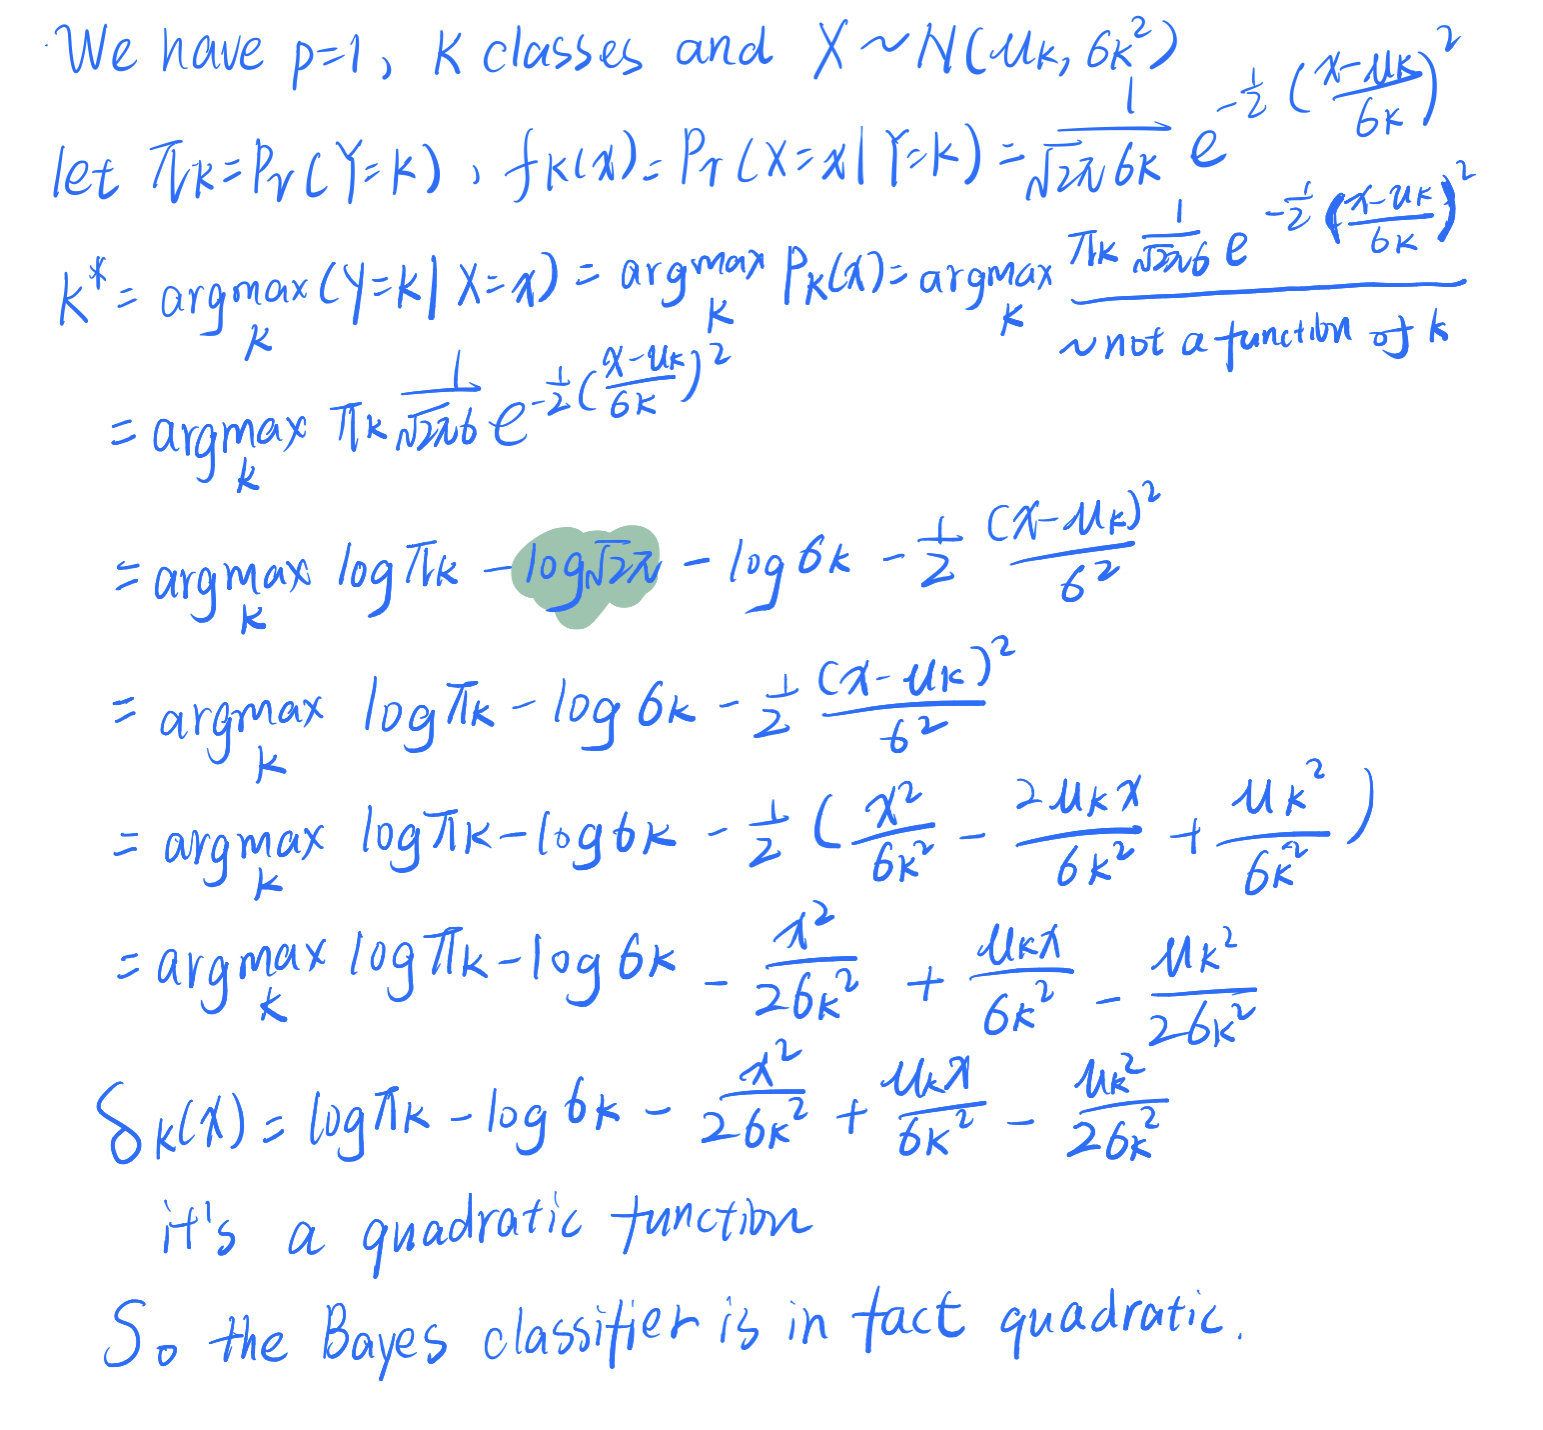

## 4. ISLR 4.8.7

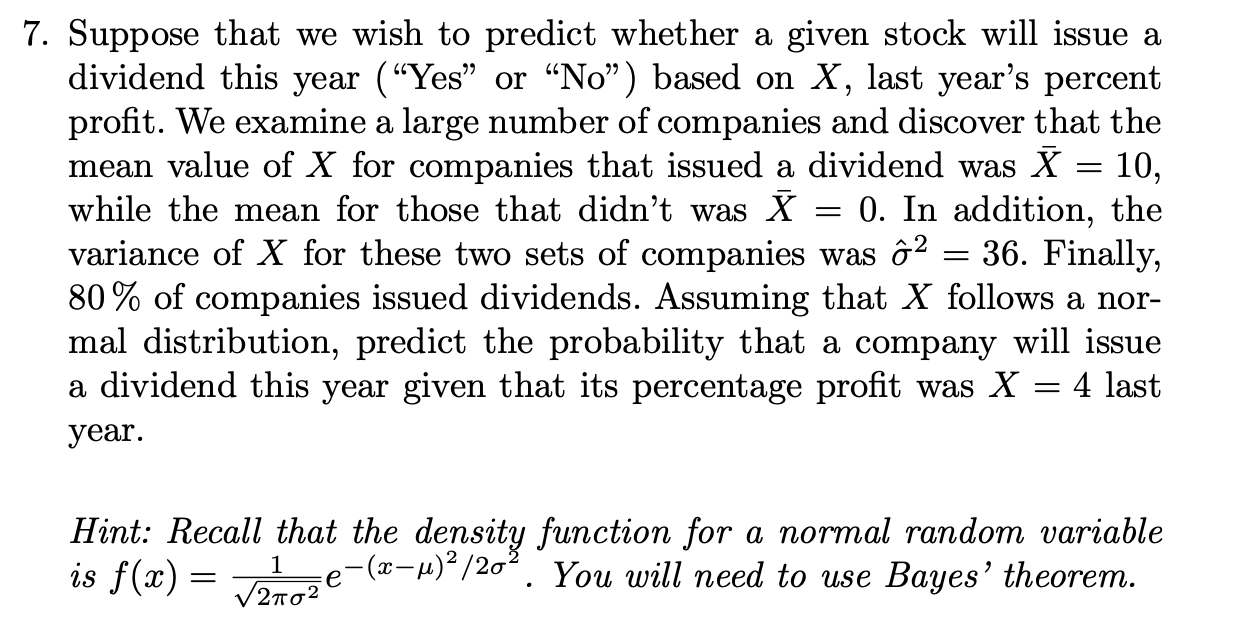

**ANSWER**:

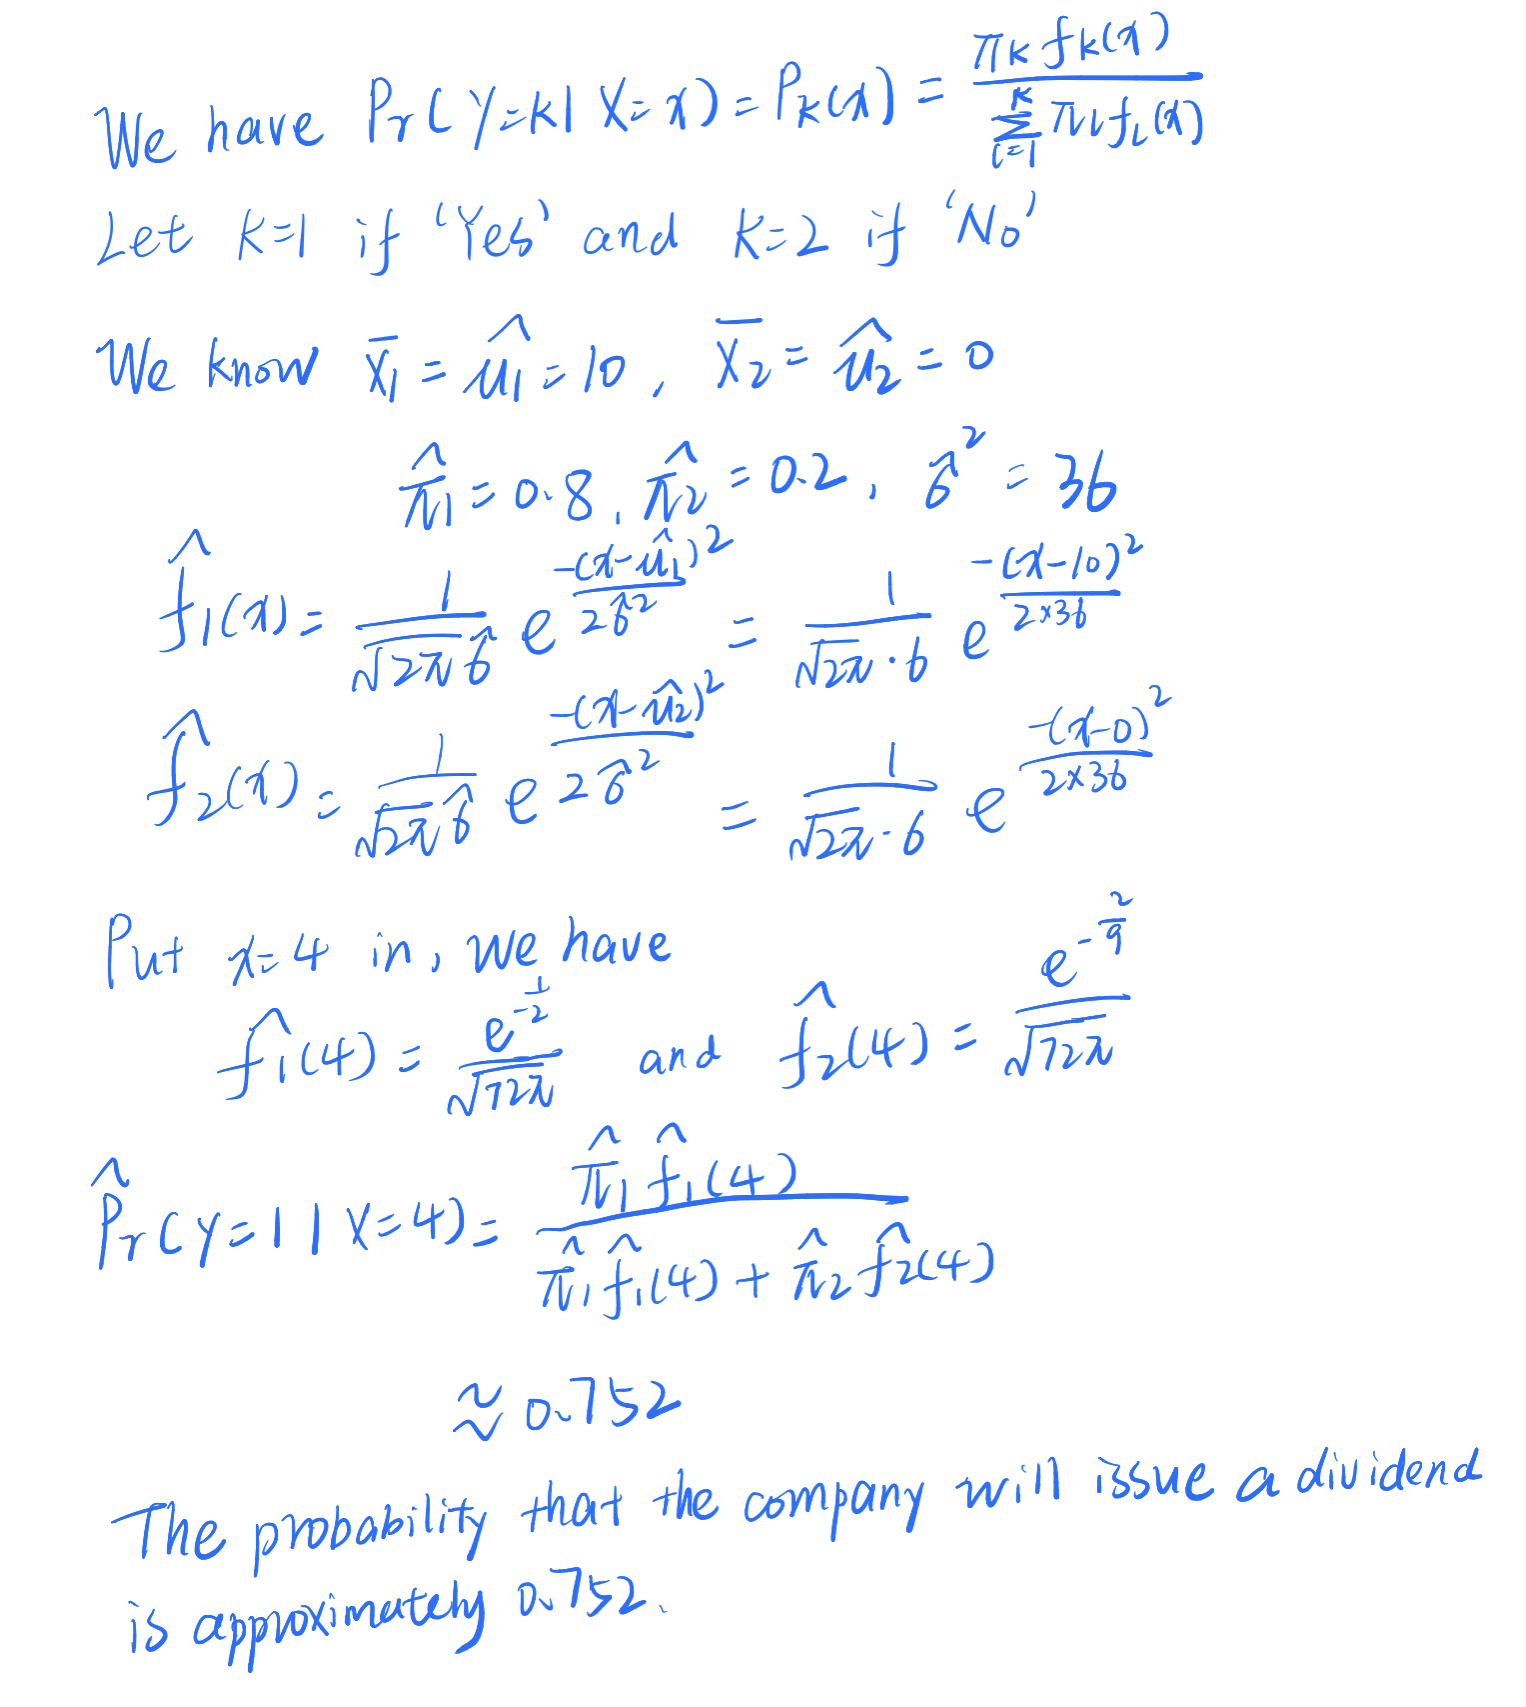

## References and Citations

#### 1. Types of time-domain features used in time series classification

Emile (https://stats.stackexchange.com/users/16137/emile), Features for time series classification, URL (version: 2014-08-21): https://stats.stackexchange.com/q/51474

#### 2. pandas.DataFrame.groupby

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html

#### 3. subscript of str

https://codeigo.com/python/printing-subscript-and-superscript

#### 4. Cross-validation

https://scikit-learn.org/stable/modules/cross_validation.html

#### 5. sklearn.linear_model.LogisticRegression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#### 6. sklearn.feature_selection.RFECV

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

#### 7. Plot ROC and AUC

https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

#### 8. Python sklearn - how to calculate p-values

https://stackoverflow.com/questions/22306341/python-sklearn-how-to-calculate-p-values

#### 9. Understanding stratified cross-validation

https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation

#### 10. pandas.DataFrame.sample

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html#pandas-dataframe-sample

#### 11. Regularization path of L1- Logistic Regression

https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_path.html

#### 12. sklearn.model_selection.GridSearchCV

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### 13. sklearn.naive_bayes.GaussianNB

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

#### 14. sklearn.naive_bayes.MultinomialNB

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html